## 📊 Scalable Feature Engineering with Frypto
With **Frypto**, a Python package designed for financial time series, you can easily generate **42 advanced features** such as price spreads, volatility indicators, momentum metrics, and more. 

In this notebook, we demonstrate:
- How **Frypto** handles a **29 million-row cryptocurrency dataset** efficiently.
- How to generate **42 engineered features** in **under 9 minutes**.
- The impact of feature engineering on model performance.

### Key Sections:
1. **Environment Setup**: Install and import all necessary libraries.
2. **Data Loading**: Load a large crypto dataset (29M rows) and preprocess it.
3. **Feature Engineering**: Use **Frypto** to generate features for each asset.
4. **Training Models**: Train models with and without Frypto features to compare performance.
5. **Results & Analysis**: Evaluate and visualize the improvement in RMSE and feature importance.


# 1. Environment Setup

### Install frypto: feature engineering package [Github Repo](https://github.com/NotAbdelrahmanelsayed/frypto) 


In [1]:
!pip install frypto 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 17.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 4.6 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=317865 sha256=95add1b4ef722d79815525cf4994567774701dee486bf6ed8464819c431414a5
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee


### Imports

In [2]:
import frypto

import warnings
import sys
import os
import gc
import pickle
import shutil
from pathlib import Path

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Ignore DeprecationWarnings and RuntimeWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.set_option("future.no_silent_downcasting", True)

# Append 'src' directory to sys.path to import local modules
sys.path.append('/kaggle/input/source')

# Import local modules
from utils import (
    read_data, fill_timestamps, 
    optimize_dataframe, weighted_correlation, evaluate_predictions,
    reduce_memory_usage, get_time_series_splits
)


# 2. Data Loading 

### Set up data paths

In [3]:
data_folder = Path('data')
outputs_dir = Path('outputs')
outputs_dir.mkdir(parents=True, exist_ok=True)
model_dir = outputs_dir / 'trained_models'
model_dir.mkdir(parents=True, exist_ok=True)
results_dir = Path('results')
results_dir.mkdir(parents=True, exist_ok=True)
feature_importance_dir = results_dir / 'feature_importance_per_asset'
feature_importance_dir.mkdir(parents=True, exist_ok=True)

### Load Data

In [4]:
train_data_path = data_folder / '/kaggle/input/g-research-crypto-forecasting/train.csv'
if train_data_path.exists():
    crypto_df = reduce_memory_usage(pd.read_csv(train_data_path))
else:
    # If 'train.csv' is not available, use 'sample.csv'
    sample_data_path = data_folder / 'sample.csv'
    if sample_data_path.exists():
        crypto_df = reduce_memory_usage(pd.read_csv(sample_data_path))
    else:
        print("No suitable data file found. Please ensure 'train.csv' or 'sample.csv' is available in the 'data' folder.")
        raise FileNotFoundError("No data file found in 'data' directory.")

Memory usage of dataframe is 1849.12 MB
Memory usage after optimization is: 716.53 MB
Decreased by 61.2%


In [5]:
# Load asset details
asset_details_path = data_folder / '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'
if asset_details_path.exists():
    asset_details = pd.read_csv(asset_details_path)
else:
    print("Asset details file 'asset_details.csv' not found in 'data' directory.")
    raise FileNotFoundError("Asset details file not found.")

### Fill missing timestamps and fill missing values using backward and forward fill.


In [6]:
preprocessed_assets = []
unique_ids = crypto_df['Asset_ID'].unique()
for id in unique_ids:
    asset_df = fill_timestamps(crypto_df, id)
    asset_df.loc[:, 'Asset_ID'] = id
    preprocessed_assets.append(asset_df)
    
del crypto_df
gc.collect()

preprocessed_df = pd.concat(preprocessed_assets)
preprocessed_df.reset_index(inplace=True)
preprocessed_df = reduce_memory_usage(preprocessed_df)
sorted_indices = np.argsort(preprocessed_df['timestamp'])
preprocessed_df = preprocessed_df.iloc[sorted_indices]

# Optional: Sample a fraction of the data for faster processing during development
# preprocessed_df = preprocessed_df.sample(frac=0.1, random_state=50)

Memory usage of dataframe is 1989.75 MB
Memory usage after optimization is: 945.13 MB
Decreased by 52.5%


# 3. Feature Engineering (Frypto)



In [7]:
%%time
%load_ext memory_profiler
%memit
print(f"using frypto for Feature engineering {len(preprocessed_df)} row....\n")
import frypto


chunk_size = 100_000  
final_df = pd.DataFrame()

for asset_id in tqdm(unique_ids, desc="Processing Assets"):
    print(f'Feature engineering at asset_id {asset_id}')
    asset_df = preprocessed_df[preprocessed_df['Asset_ID'] == asset_id]
    
    num_chunks = (len(asset_df) // chunk_size) + 1
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        chunk_df = asset_df.iloc[start_idx:end_idx].copy()
        feature_engineer = frypto.AllFeatures(chunk_df) # Frypto goes here
        df = feature_engineer.compute() # Frypto goes here

        # Append processed chunk to final DataFrame
        final_df = pd.concat([final_df, df], ignore_index=True)

        # Free memory
        del chunk_df, feature_engineer
        gc.collect()
final_df = pd.concat([preprocessed_df, final_df], axis="columns")
# del preprocessed_df
print()
gc.collect()

peak memory: 3923.91 MiB, increment: 0.17 MiB
using frypto for Feature engineering 26080043 row....



Processing Assets:   0%|          | 0/14 [00:00<?, ?it/s]

Feature engineering at asset_id 2


Processing Assets:   7%|▋         | 1/14 [00:11<02:30, 11.58s/it]

Feature engineering at asset_id 0


Processing Assets:  14%|█▍        | 2/14 [00:26<02:43, 13.59s/it]

Feature engineering at asset_id 1


Processing Assets:  21%|██▏       | 3/14 [00:46<02:59, 16.27s/it]

Feature engineering at asset_id 5


Processing Assets:  29%|██▊       | 4/14 [01:09<03:11, 19.14s/it]

Feature engineering at asset_id 7


Processing Assets:  36%|███▌      | 5/14 [01:37<03:19, 22.18s/it]

Feature engineering at asset_id 6


Processing Assets:  43%|████▎     | 6/14 [02:08<03:22, 25.35s/it]

Feature engineering at asset_id 9


Processing Assets:  50%|█████     | 7/14 [02:44<03:21, 28.79s/it]

Feature engineering at asset_id 11


Processing Assets:  57%|█████▋    | 8/14 [03:24<03:13, 32.32s/it]

Feature engineering at asset_id 13


Processing Assets:  64%|██████▍   | 9/14 [04:16<03:13, 38.64s/it]

Feature engineering at asset_id 12


Processing Assets:  71%|███████▏  | 10/14 [05:02<02:43, 40.76s/it]

Feature engineering at asset_id 3


Processing Assets:  79%|███████▊  | 11/14 [05:51<02:09, 43.19s/it]

Feature engineering at asset_id 8


Processing Assets:  86%|████████▌ | 12/14 [06:40<01:30, 45.15s/it]

Feature engineering at asset_id 10


Processing Assets:  93%|█████████▎| 13/14 [07:33<00:47, 47.50s/it]

Feature engineering at asset_id 4


Processing Assets: 100%|██████████| 14/14 [08:14<00:00, 35.29s/it]



CPU times: user 5min 16s, sys: 3min 11s, total: 8min 27s
Wall time: 8min 28s


0

In [8]:
# Apply memory optimization
final_df = reduce_memory_usage(final_df)
gc.collect()
final_df.sample(5)

Memory usage of dataframe is 7809.77 MB
Memory usage after optimization is: 3432.32 MB
Decreased by 56.1%


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,+DI,-DI,ADX,support_line,resistance_line,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span
10715724,1570620300,6.0,284.0,183.625000,184.125000,183.000000,183.375000,800.968445,183.418632,-0.000692,...,8.570312,5.714286,32.218750,NaN,NaN,183.750000,184.000000,183.875000,183.500000,183.625000
21982284,1569636540,8.0,5.0,0.259521,0.259521,0.258301,0.259277,418.940002,0.259176,0.259176,...,11.539062,17.307692,25.953125,0.259277,NaN,0.259766,0.260986,0.261963,0.261963,0.260742
4624688,1557410940,1.0,338.0,6056.000000,6200.000000,6004.000000,6052.000000,73.862038,6053.387135,0.001380,...,0.263184,0.526316,38.656250,NaN,NaN,6104.000000,6088.000000,6088.000000,6096.000000,6052.000000
16158711,1548134880,13.0,50.0,0.026031,0.026306,0.025879,0.026031,339841.906250,0.026033,-0.008751,...,50.312500,0.653595,97.000000,NaN,NaN,0.026123,0.026154,0.026123,0.026093,0.025818
9155368,1594416540,7.0,39.0,6.339844,6.343750,6.332031,6.339844,877.947205,6.338884,0.001445,...,14.632812,9.756098,33.687500,NaN,NaN,6.347656,6.367188,6.363281,6.367188,6.339844


In [9]:
final_df.columns

Index(['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP', 'Target', 'Price_change', 'next_log_return',
       'high_low_spread', 'close_open_spread', 'rolling_std', 'upper_band',
       'lower_band', 'ATR', 'RSI', 'MACD', 'Signal_Line', 'SMA', 'EMA', 'ROC',
       'Skew_20', 'Kurtosis_20', 'ZScore_20', 'volume_change', 'OBV', 'lag_1',
       'lag_2', 'lag_3', 'rolling_mean_5', 'rolling_max_5', 'rolling_min_5',
       'rolling_mean_10', 'rolling_max_10', 'rolling_min_10',
       'rolling_mean_20', 'rolling_max_20', 'rolling_min_20', '+DI', '-DI',
       'ADX', 'support_line', 'resistance_line', 'tenkan_sen', 'kijun_sen',
       'senkou_span_a', 'senkou_span_b', 'chikou_span'],
      dtype='object')

Taking samples from the dataset to train the models faster

In [10]:
df_with_features = final_df.sample(frac=0.1, random_state=50)
df_without_features = preprocessed_df.sample(frac=0.1, random_state=50)

# 4. Training Models

### Training function

In [11]:
EXCLUDE_COLUMNS = ['timestamp', 'Asset_ID', 'Date', 'Target', 'Volume', 'Count']
def train_models(df, dataset_name):
    print(f"\nTraining models on dataset: {dataset_name}")
    
    # Initialize variables for storing results
    oof_predictions = []
    oof_targets = []
    feature_importances = pd.DataFrame()
    
    # Get the unique asset IDs
    unique_ids = df['Asset_ID'].unique()
    
    for asset_id in unique_ids:
        print(f"\nTraining model for Asset ID {asset_id}")
        
        # Filter data for the asset
        asset_data = df[df['Asset_ID'] == asset_id].copy()
        asset_data.reset_index(drop=True, inplace=True)
        
        # Skip assets with insufficient data
        if len(asset_data) < 500:
            print(f"Not enough data for Asset ID {asset_id}. Skipping.")
            continue
        
        # Define features and target
        TARGET = 'Target'
        FEATURES = [col for col in asset_data.columns if col not in EXCLUDE_COLUMNS]
        
        # Handle missing values and ensure numeric data
        asset_data[FEATURES] = asset_data[FEATURES].apply(pd.to_numeric, errors='coerce')
        asset_data[FEATURES] = asset_data[FEATURES].fillna(0)
        asset_data[TARGET] = asset_data[TARGET].fillna(0)
        
        # Initialize OOF predictions
        oof_pred = np.zeros(len(asset_data))
        
        # Time series split
        tscv = TimeSeriesSplit(n_splits=5)
        for fold, (train_idx, valid_idx) in enumerate(tscv.split(asset_data)):
            print(f"Fold {fold + 1}")
            
            X_train, X_valid = asset_data.loc[train_idx, FEATURES], asset_data.loc[valid_idx, FEATURES]
            y_train, y_valid = asset_data.loc[train_idx, TARGET], asset_data.loc[valid_idx, TARGET]

            # Replace infinite values and fill NaNs with appropriate values in features
            X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
            X_valid.replace([np.inf, -np.inf], np.nan, inplace=True)
            X_train.fillna(0, inplace=True)
            X_valid.fillna(0, inplace=True)
    
            # Replace infinite values and fill NaNs in target variable
            y_train.replace([np.inf, -np.inf], np.nan, inplace=True)
            y_valid.replace([np.inf, -np.inf], np.nan, inplace=True)
            y_train.fillna(0, inplace=True)
            y_valid.fillna(0, inplace=True)
    
            # Ensure that there are no more invalid values in the target
            if np.isnan(y_train.values).any() or np.isinf(y_train.values).any():
                print("There are still NaN or infinite values in y_train after cleaning.")
                continue
            if np.isnan(y_valid.values).any() or np.isinf(y_valid.values).any():
                print("There are still NaN or infinite values in y_valid after cleaning.")
                continue
            
            # Scale the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_valid_scaled = scaler.transform(X_valid)
            
            # Initialize and train the model
            model = LGBMRegressor(
                objective='regression',
                learning_rate=0.05,
                num_leaves=31,
                n_estimators=500,
                random_state=42 + fold,
                n_jobs=-1,
                verbosity=1
                
            )
            model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_valid_scaled, y_valid)],
                eval_metric='rmse',
            )
            
            # Predict on validation set
            y_pred_valid = model.predict(X_valid_scaled)
            oof_pred[valid_idx] = y_pred_valid
            
            # Collect feature importances
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = FEATURES
            fold_importance_df["importance"] = model.feature_importances_
            fold_importance_df["fold"] = fold + 1
            fold_importance_df["asset_id"] = asset_id
            feature_importances = pd.concat([feature_importances, fold_importance_df], axis=0)
            
            # Clean up
            del X_train, X_valid, y_train, y_valid, X_train_scaled, X_valid_scaled
            gc.collect()
        
        # Calculate OOF RMSE for the asset
        asset_rmse = np.sqrt(mean_squared_error(asset_data[TARGET], oof_pred))
        print(f"Asset ID {asset_id} OOF RMSE: {asset_rmse:.6f}")
        
        # Store predictions and targets
        oof_predictions.extend(oof_pred)
        oof_targets.extend(asset_data[TARGET])
        
        # Clean up
        del asset_data, oof_pred
        gc.collect()
    
    # Calculate overall OOF RMSE
    overall_rmse = np.sqrt(mean_squared_error(oof_targets, oof_predictions))
    print(f"\nOverall OOF RMSE for dataset '{dataset_name}': {overall_rmse:.6f}")
    
    return oof_predictions, oof_targets, feature_importances



### Train the model on the dataset with and without frypto features

In [12]:
# Train model with engineered features
oof_preds_with_features, oof_targets_with_features, feature_importances_with = train_models(df_with_features, 'with_features')

# Train model without engineered features
oof_preds_without_features, oof_targets_without_features, feature_importances_without = train_models(df_without_features, 'without_features')



Training models on dataset: with_features

Training model for Asset ID 12.0
Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11342
[LightGBM] [Info] Number of data points in the train set: 31420, number of used features: 46
[LightGBM] [Info] Start training from score 0.027081
Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11379
[LightGBM] [Info] Number of data points in the train set: 62840, number of used features: 46
[LightGBM] [Info] Start training from score 0.026875
Fold 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11413
[LightGBM] [Info] N

# 5. Results & Analysis

### Aggreegate feature importance

In [13]:
def aggregate_feature_importances(feature_importances):
    # Group by feature and calculate mean importance
    aggregated_importance = feature_importances.groupby('feature')['importance'].mean().reset_index()
    # Sort features by importance
    aggregated_importance.sort_values(by='importance', ascending=False, inplace=True)
    return aggregated_importance

# For model with features
aggregated_importance_with = aggregate_feature_importances(feature_importances_with)

# For model without features
aggregated_importance_without = aggregate_feature_importances(feature_importances_without)



### Plot Feature Importance

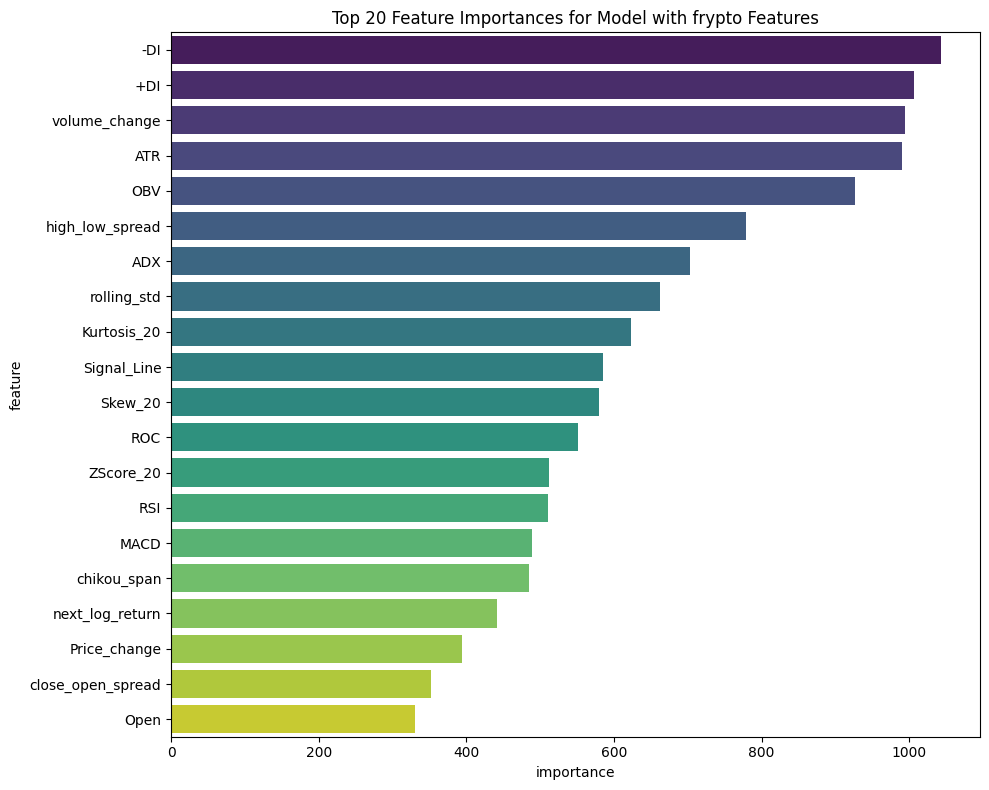

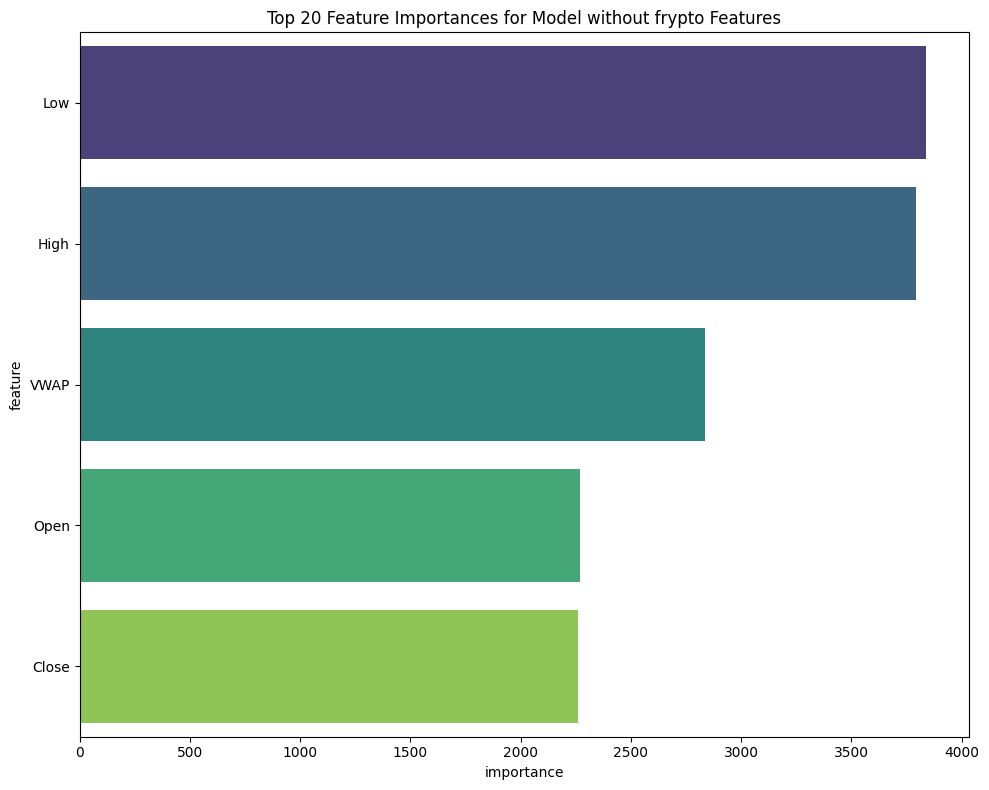

In [14]:
def plot_feature_importances(aggregated_importance, dataset_name, top_n=20):
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=aggregated_importance.head(top_n),
        palette='viridis'
    )
    plt.title(f'Top {top_n} Feature Importances for {dataset_name}')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{dataset_name}.png')
    plt.show()

# Model with features
plot_feature_importances(aggregated_importance_with, 'Model with frypto Features')

# Model without features
plot_feature_importances(aggregated_importance_without, 'Model without frypto Features')


### Calculate RMSE for models with and without Frypto features

In [15]:
rmse_with_features = np.sqrt(mean_squared_error(oof_targets_with_features, oof_preds_with_features))
rmse_without_features = np.sqrt(mean_squared_error(oof_targets_without_features, oof_preds_without_features))

print(f"\nRMSE with engineered features: {rmse_with_features:.6f}")
print(f"RMSE without engineered features: {rmse_without_features:.6f}")
print(f"RMSE Improvement: {rmse_without_features - rmse_with_features:.6f}")


RMSE with engineered features: 69.573486
RMSE without engineered features: 84.883070
RMSE Improvement: 15.309585


## 📈 Summary and Takeaways

1. **Efficiency**: Frypto processed 29M rows and generated 42 features in under 9 minutes.
2. **Scalability**: Chunked processing and memory optimization allowed us to handle a massive dataset efficiently.
3. **Impact on Model Performance**:
   - **With Frypto Features**: 69.573486
   - **Without Features**: 84.883070
   - **Improvement**: 15.309585

This demonstrates the power of advanced feature engineering in improving prediction accuracy for crypto datasets.datasets.
